In [103]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib import gridspec
from matplotlib import colorbar
from matplotlib import gridspec
from matplotlib import colors
import matplotlib as mpl
import pandas as pd
import os
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in", "ytick.direction": "in"})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.2, as_cmap=True)

In [2]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]

In [3]:
g_grid = np.zeros([metal.size,age.size,len(tau)])
for i in range(metal.size):
    g_grid[i]=np.load('../data/m%s_gbf.npy' % metal[i]).T
    
age_conv = np.load('../data/light_weight_scaling_2.npy')

In [4]:
l_dist= age_conv[17].T

In [5]:
ultau=np.append(0,10**(np.array(tau[1:])-9))

In [11]:
def SFH(AGE,TAU):
    return AGE*np.exp(-AGE/TAU)

In [27]:
def LWA(dist,tau):
    top = np.zeros(len(dist))
    bottom = np.zeros(len(dist))

    for i in range(len(dist)):
        top[i] = np.trapz(SFH(age,tau)[0:i+1] * dist[0:i+1] * (age[i] - age[0:i+1]),age[0:i+1])
        bottom[i] = np.trapz(SFH(age,tau)[0:i+1]*dist[0:i+1],age[0:i+1])
    
    return top/bottom

In [23]:
test = LWA(g_dist[5][::-1],ultau[6])

/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


<function matplotlib.pyplot.close>

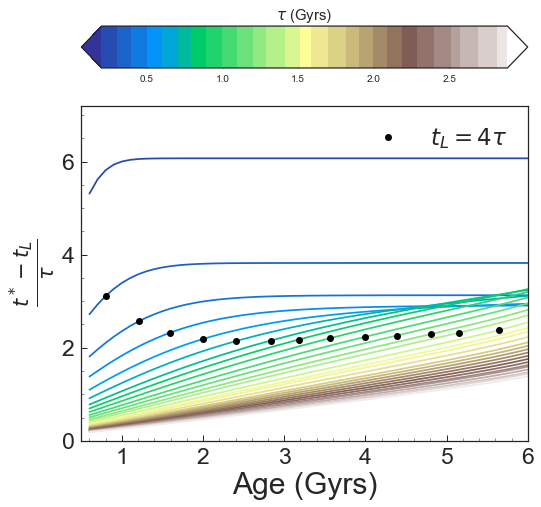

In [121]:
%matplotlib inline

col_list = sea.mpl_palette('terrain',ultau[1:].size)

gs =gridspec.GridSpec(2,1,height_ratios=[1,8])
plt.figure(figsize=[8,8])
ax = plt.subplot(gs[0])
cmap = mpl.cm.get_cmap('terrain')

bounds =ultau[1:]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                extend='both',
                                ticks=[.1,.5,1.0,1.5,2.0,2.5,3.0],
                                spacing='proportional',
                                orientation='horizontal')
plt.tick_params(axis='x', which='major', labelsize=10)
plt.title('$\\tau$ (Gyrs)',fontsize=15)

plt.subplot(gs[1])
for i in range(len(l_dist)-1):
    plt.plot(age,(age - l_dist[i+1])/ultau[i+1],color=col_list[i])
    
    if .5 <= ultau[i+1]*4 <= 6: 
        plt.plot(ultau[i+1]*4,interp1d(age,(age - l_dist[i+1])/ultau[i+1])(ultau[i+1]*4),'ko')
plt.plot(0,0,'ko',label = '$t_L = 4\\tau$')
plt.legend(loc=1,fontsize=23)
plt.axis([.5,6,0,7.2])
plt.xlabel('Age (Gyrs)',fontsize=30)
plt.ylabel('$\\frac{t^* - t_L}{\\tau}$',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.savefig('../plots/tau_limit.pdf',bbox_inches = 'tight')
plt.close

In [97]:
ultau[1:]

array([ 0.1       ,  0.19952623,  0.30199517,  0.39810717,  0.50118723,
        0.60255959,  0.70794578,  0.79432823,  0.89125094,  1.        ,
        1.0964782 ,  1.20226443,  1.28824955,  1.41253754,  1.51356125,
        1.58489319,  1.69824365,  1.81970086,  1.90546072,  1.99526231,
        2.08929613,  2.18776162,  2.29086765,  2.39883292,  2.51188643,
        2.57039578,  2.6915348 ,  2.81838293,  2.8840315 ,  3.01995172])

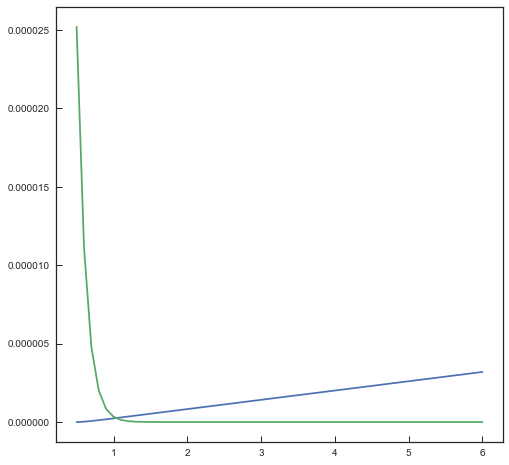

In [31]:
%matplotlib inline

plt.figure(figsize=[8,8])
plt.plot(age,LWA_top(g_dist[0][::-1],ultau[1]))
plt.plot(age,Top_dist(metal[17],6,8.0))